In [1]:
# Main library: https://square.github.io/pysurvival/index.html
#----------------------------Reproducible------------------------------------------
import numpy as np
import random as rn
import pandas as pd
import gc
import os

seed=0
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
rn.seed(seed)

#----------------------------Reproducible------------------------------------------

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.model_selection import train_test_split
from pysurvival.models.semi_parametric import NonLinearCoxPHModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score
from pysurvival.utils.display import display_loss_values
from pysurvival.utils.display import compare_to_actual

from lifelines import KaplanMeierFitter
from matplotlib import pyplot as plt

import heapq
import seaborn as sns

In [2]:
def csv_read(p_path):
    pd_data=pd.read_csv(p_path, sep=',')
    column_names=pd_data.columns.values.tolist()
    print(column_names)
    return pd_data,column_names

def write_to_csv(p_data,p_path):
    dataframe = pd.DataFrame(p_data)
    dataframe.to_csv(p_path, mode='a',header=False,index=False,sep=',')
    del dataframe
    gc.collect()

In [3]:
data,column_names=csv_read('./data/survival_data_filtered_3.csv')

['NACCREAS', 'NACCREFR', 'BIRTHMO', 'BIRTHYR', 'SEX', 'HISPANIC', 'HISPOR', 'RACE', 'RACESEC', 'RACETER', 'PRIMLANG', 'EDUC', 'MARISTAT', 'NACCLIVS', 'INDEPEND', 'RESIDENC', 'HANDED', 'NACCFADM', 'NACCFFTD', 'MEMORY', 'ORIENT', 'JUDGMENT', 'COMMUN', 'HOMEHOBB', 'PERSCARE', 'CDRSUM', 'DECSUB', 'DECIN', 'COGMEM', 'COGJUDG', 'COGLANG', 'COGVIS', 'COGATTN', 'COGOTHR', 'NACCCOGF', 'COGMODE', 'DECAGE', 'BEAPATHY', 'BEDEP', 'BEVHALL', 'BEAHALL', 'BEDEL', 'BEDISIN', 'BEIRRIT', 'BEAGIT', 'BEPERCH', 'BEOTHR', 'NACCBEHF', 'BEMODE', 'MOGAIT', 'MOFALLS', 'MOTREM', 'MOSLOW', 'NACCMOTF', 'MOMODE', 'COURSE', 'FRSTCHG', 'NORMCOG', 'DEMENTED', 'NACCPPA', 'NACCBVFT', 'NACCLBDS', 'NACCTMCI', 'NACCMCIL', 'NACCMCIA', 'NACCMCIE', 'NACCMCIV', 'NACCMCII', 'IMPNOMCI', 'NACCALZD', 'NACCALZP', 'NACCLBDE', 'NACCLBDP', 'PARK', 'PSP', 'PSPIF', 'CORT', 'CORTIF', 'DOWNS', 'DOWNSIF', 'HUNT', 'HUNTIF', 'PRION', 'PRIONIF', 'BRNINJ', 'BRNINJIF', 'HYCEPH', 'HYCEPHIF', 'NEOP', 'NEOPIF', 'DEP', 'DEPIF', 'OTHPSY', 'OTHPSYIF',

In [4]:
data

,NACCREAS,NACCREFR,BIRTHMO,BIRTHYR,SEX,HISPANIC,HISPOR,RACE,RACESEC,RACETER,...,NPBNKB,NACCFORM,NACCPARA,NACCCSFP,NPBNKF,NPFAUT,NACCDAGE,NACCINT,SurvivalTime,Event
0,1,2,1,1942,2,0,88,1,88,88,...,1,1,1,1,0,9,77,66,2212,False
1,1,9,12,1928,1,0,88,1,88,88,...,1,1,1,1,0,0,90,5,1834,False
2,1,2,4,1926,2,0,88,1,88,88,...,0,1,1,1,0,0,89,43,959,True
3,1,8,3,1925,2,0,88,1,3,88,...,1,0,1,0,0,0,93,10,721,False
4,2,9,8,1947,2,0,88,1,88,88,...,0,1,1,0,0,0,68,31,2520,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684,1,1,8,1935,2,0,88,1,88,88,...,1,1,1,0,0,0,83,0,4059,True
685,1,1,4,1937,1,0,88,1,88,88,...,0,1,1,0,0,0,80,35,1856,True
686,1,1,3,1945,1,0,88,1,88,88,...,1,1,1,1,0,9,72,23,364,True
687,2,2,7,1940,1,0,88,1,88,88,...,0,1,1,0,0,0,76,9,364,True


In [5]:
Events=np.array(data.loc[:,'Event'])
print("%.2f%% samples are right censored in whole data." % (np.sum(~Events) * 100. / len(Events)))

59.22% samples are right censored in whole data.


In [6]:
X=data.loc[:,'NACCREAS':'NACCINT']
y_=data.loc[:,'SurvivalTime':'Event']
y=np.array([(y__[1],y__[0]) for y__ in np.array(y_)], dtype=[('Event', 'bool'), ('SurvivalTime', '<f8')])

models=[]
structure = [ {'activation': 'BentIdentity', 'num_units': 150},  ]
seed_num=5
epoch_num=2000

for seed_i in [3]:

    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=seed_i)

    time_train=y_train['SurvivalTime']
    event_train=y_train['Event']
    time_test=y_test['SurvivalTime']
    event_test=y_test['Event']

    # Building the model
    nonlinear_coxph = NonLinearCoxPHModel(structure=structure)
    nonlinear_coxph.fit(X_train, time_train, event_train, num_epochs = epoch_num,lr=1e-4, init_method='glorot_uniform')

    models.append(nonlinear_coxph)

% Completion: 100%|***********************************************|Loss: 791.78


C-index: 0.82


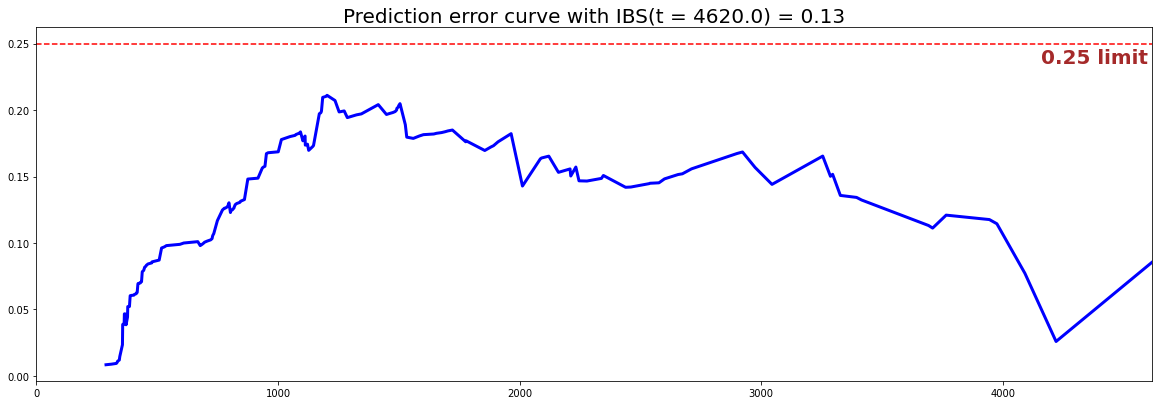

IBS: 0.13


In [9]:
# Model Performances
c_index = concordance_index(models[0], X_test, time_test, event_test) #0.81
print('C-index: {:.2f}'.format(c_index))

ibs = integrated_brier_score(models[0], X_test, time_test, event_test, t_max=None, figure_size=(20, 6.5) )
print('IBS: {:.2f}'.format(ibs))

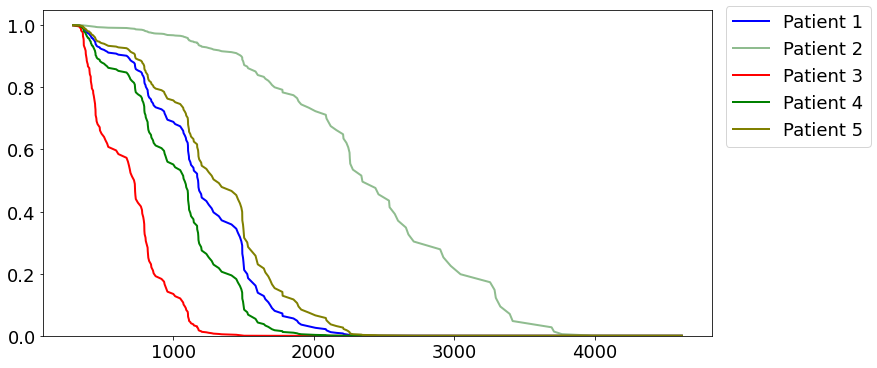

In [30]:
cs=['blue','darkseagreen','red','green','olive','cyan','tan','silver','purple','fuchsia','chocolate','darkcyan','aqua','pink','orange','bisque','lightsteelblue']

np.random.seed(2)
# Randomly extracting a data-point that experienced an event 
choices = np.argwhere((event_test==1.)&(time_test>=1)).flatten()
k_list = np.random.choice( choices, 5,replace=False)


fig, ax = plt.subplots(figsize=(12, 6))
    
# Saving the time of event
for i in np.arange(len(k_list)):
    k=k_list[i]
    t = time_test[k]

    # Computing the Survival function for all times t
    predicted = models[0].predict_survival(X_test.values[k, :]).flatten()

    # Displaying the functions
    plt.plot(models[0].times, predicted, color=cs[i], label='Patient '+str(i+1), lw=2)
    
      
plt.legend(loc=[1.02,0.58],fontsize=18, ncol=1)
plt.ylim(0, 1.05)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

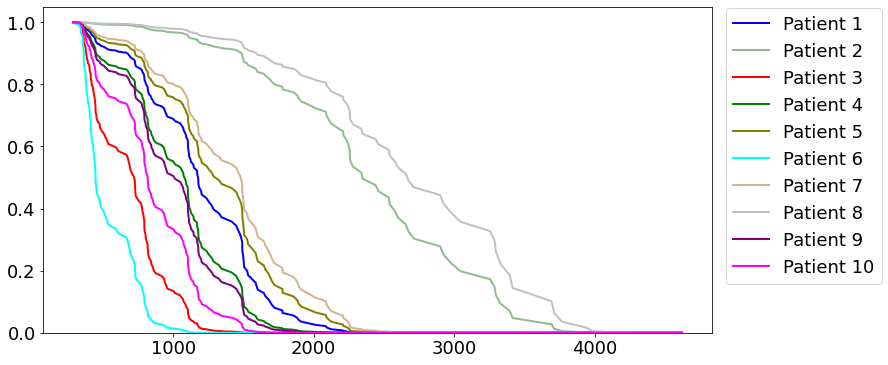

In [31]:
np.random.seed(2)
# Randomly extracting a data-point that experienced an event 
choices = np.argwhere((event_test==1.)&(time_test>=1)).flatten()
k_list = np.random.choice( choices, 10,replace=False)


fig, ax = plt.subplots(figsize=(12, 6))
    
# Saving the time of event
for i in np.arange(len(k_list)):
    k=k_list[i]
    t = time_test[k]

    # Computing the Survival function for all times t
    predicted = models[0].predict_survival(X_test.values[k, :]).flatten()

    # Displaying the functions
    plt.plot(models[0].times, predicted, color=cs[i], label='Patient '+str(i+1), lw=2)
    
      
plt.legend(loc=[1.02,0.15],fontsize=18, ncol=1)
plt.ylim(0, 1.05)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

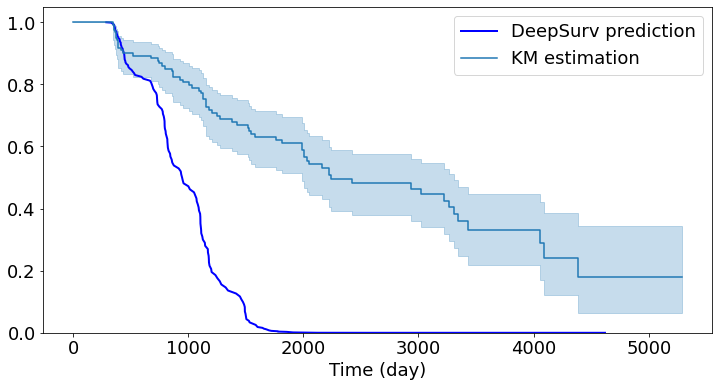

In [32]:
np.random.seed(2)

# Randomly extracting a data-point that experienced an event 
choices = np.argwhere((event_test==1.)&(time_test>=1)).flatten()
k = np.random.choice( choices, 1)[0]
        
kmf = KaplanMeierFitter()
fig, ax = plt.subplots(figsize=(12, 6))

# Saving the time of event
t = time_test[k]

# Computing the Survival function for all times t
predicted = models[0].predict_survival(X_test.values[k, :]).flatten()

# Displaying the functions
plt.plot(models[0].times, predicted, color='blue', label='DeepSurv prediction', lw=2)

kmf.fit(time_test, event_observed=event_test)
ax = kmf.plot_survival_function(ax=ax,label="KM estimation")

# Show everything
plt.legend(fontsize=18)
plt.ylim(0, 1.05)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Time (day)',fontsize=18)
plt.show()

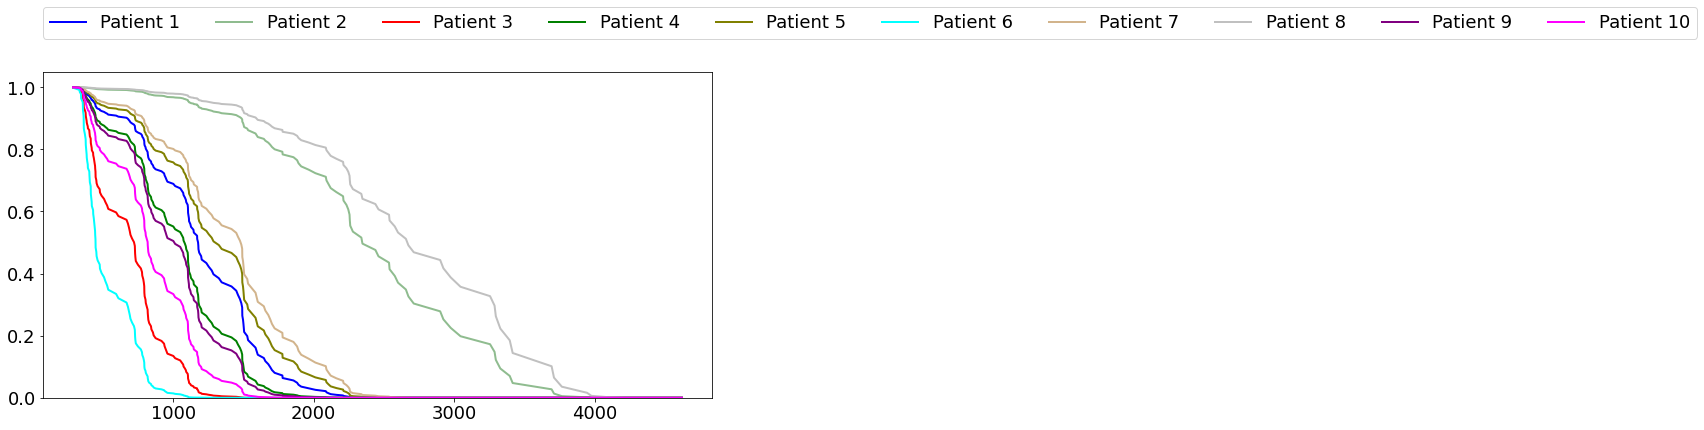

In [34]:
np.random.seed(2)
# Randomly extracting a data-point that experienced an event 
choices = np.argwhere((event_test==1.)&(time_test>=1)).flatten()
k_list = np.random.choice( choices, 10,replace=False)


fig, ax = plt.subplots(figsize=(12, 6))
    
# Saving the time of event
for i in np.arange(len(k_list)):
    k=k_list[i]
    t = time_test[k]

    # Computing the Survival function for all times t
    predicted = models[0].predict_survival(X_test.values[k, :]).flatten()

    # Displaying the functions
    plt.plot(models[0].times, predicted, color=cs[i], label='Patient '+str(i+1), lw=2)
    
      
plt.legend(loc=[0.0,1.1],fontsize=18, ncol=10)
plt.ylim(0, 1.05)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()